# Intergalactic propagation of gamma rays

This notebook exemplifies how to simulate the propagation of gamma ray over cosmological distances
It considers an astrophysical object at a given distance emitting gamma rays according to a power law $E^{-\alpha}$, with an exponential cut-off at a characteristic energy $E_\mathrm{max}$.
The simulation is done assuming this spectrum to be $E^{-1}$, but at the post-processing stage any desired spectral index can be obtained.
The object in question is GRB 221009A, the brightest-ever GRB.

### Assembling the simulation

The assemblage of the simulation modules goes as in example 3. 
We define a source, which generates a sample of candidates according to the chosen distributions to be propagated.
We then add all relevant propagation modules (for motion, interactions, decays, etc), and an observer, in addition to the break conditions.

An additional observer of very small size is added to the simulation to collect the spectrum of the emitted particles.
This is just for illustration, as it is not used later. 
In real-world applications, that would be useful for normalising, for instance, the luminosity of an object.

(This simulation can take up to 10 minutes, depending on the machine.)

In [14]:
from crpropa import *


# general options
nEvents = 1000
energyMinimum = 1 * GeV
energyMaximum = 100 * TeV # should be larger, but time-consuming
redshift = 0.151
distance = redshift2ComovingDistance(redshift)
sourcePosition = Vector3d(distance, 0, 0)
electrons = photons = True
thinning = 1. # optimises the simulation time
cmb = CMB()
ebl = IRB_Gilmore12()
outputFile = 'sim/sim-gamma-GRB2201009A.txt'
outputFile0 = 'sim/sim-gamma-GRB2201009A_emission.txt'

# source distribution: uniform with power-law spectrum
position = SourcePosition(sourcePosition)
direction = SourceDirection(Vector3d(-1, 0, 0)) # emit in the -x direction (1D simulation)
redshifts = SourceRedshift1D() # takes the positions and assign the corresponding redshifts
energySpectrum = SourcePowerLawSpectrum(energyMinimum, energyMaximum, -1)
particleType = SourceParticleType(22) # we are interested in gamma rays
source = Source()
source.add(position)
source.add(redshifts) 
source.add(direction)
source.add(energySpectrum)
source.add(particleType)

# output
outputType = Output.Event1D
output = TextOutput(outputFile, outputType)
output.enable(output.WeightColumn) # since we are using thinning
output.setEnergyScale(eV)
output.setLengthScale(Mpc)

# observer 
observerType = Observer1D()
electronVeto = ObserverElectronVeto()
observer = Observer()
observer.add(observerType)
observer.add(electronVeto)
observer.onDetection(output)

# to collect the emitted particles
# just to illustrate the strategy; won't be used in the end
output0 = TextOutput(outputFile0, outputType)
output0.setEnergyScale(eV)
output0.setLengthScale(Mpc)
output0.enable(output.WeightColumn) # since we are using thinning
observerSource = Observer()
observerSource.add(ObserverSurface(Sphere(sourcePosition, 0.1 * kpc)))
observerSource.add(ObserverElectronVeto())
observerSource.onDetection(output0)
observerSource.setDeactivateOnDetection(False)

# interactions
ppCMB = EMPairProduction(cmb, electrons, thinning)
ppEBL = EMPairProduction(ebl, electrons, thinning)
icsCMB = EMInverseComptonScattering(cmb, photons, thinning)
icsEBL = EMInverseComptonScattering(ebl, photons, thinning)
z = Redshift()
processes = [ppCMB, ppEBL, icsCMB, icsEBL, z]

# propagator: one-dimensional
propagator = SimplePropagation(0.1 * kpc, 100 * kpc)

# break conditions
breakEnergy = MinimumEnergy(1 * GeV)

# assemble simulation components
sim = ModuleList()
sim.add(propagator)
for interaction in processes:
	sim.add(interaction)
sim.add(observer)
sim.add(observerSource)
sim.add(breakEnergy)
sim.setShowProgress(True)
sim.run(source, nEvents, True)

output.close()


crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Thu May 22 19:38:21 2025 : [ Finished ] 100%    Needed: 00:00:34  - Finished at Thu May 22 19:38:55 2025


### Helper functions

Here we define some functions to read the simulations and compute the spectrum.
This includes de reweighting procedure to take the simulations from the way it was done (spectrum $E^{-1}$ without a cut-off), to the desired scenario (spectrum $E^{-\alpha}$ with exponential cut-off at $E_\text{max}$).
Because thinning was used to speed up this simulation, the weights should also take into account the intrinsic weights of the simulation due to thinning.

In [ ]:
import numpy as np
import pandas as pd


def readSimulation(filename):
	"""
	Read a simulation and return a pandas dataframe with the output, inferring the column names from the first line.
	"""
	with open(filename, 'r') as f:
		line = f.readline()
		line = line.replace('\n', '').replace('#', '')
		names = line.split('\t')[1:]	
	return pd.read_csv(filename, delimiter = '\t', comment = '#', names = names)

def reweightSimulation(df, alpha, Emax, columnName = 'W1', alpha0 = 1.):
	"""
	Given a pandas dataframe with the simulation, this function the correct weights (called `W1`)
	The simulation is assumed to have a spectrum E^-a0, with a0=1 in this case.

	# Input
	. `df`: pandas dataframe containing the simulations \\
	. `alpha`: desired spectral index \\
	. `Emax`: spectrum cuts off above Emax \\
	. `columnName`: name of the column to be created; defaults to 'W1' \\
	. `alpha0`: injection spectrum used in the simulation \\
	"""
	# compute weights for reweighting procedure
	computeWeight = lambda e0: e0 ** (alpha0 - alpha) * np.exp(- e0 / (Emax))
	w = np.array([w0 * computeWeight(e0) for e0, w0 in zip(df['E0'], df['W'])])
	df[columnName] = w / np.sum(w)

def computeSpectrum(df, columnName = 'W1'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum.
	Note that 

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	bins = np.logspace(9, 15, 20)
	y, edges = np.histogram(df['E'], bins = bins, weights = df[columnName])
	x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
	y /= np.diff(edges)
	y *= (x ** 2) # for E^2 dN/dE
	y /= np.amax(y)

	return x, y

### Analysis

Here we analyse the simulations and post-process them, applying the appropriate reweighting procedure.
To understand how the reweighting procedure works, we use several spectral indices and maximal energies.

In [12]:
data = readSimulation(outputFile)
data0 = readSimulation(outputFile0)

# spectral indices, cut-off energies
alpha1 = 1.5
alpha2 = 2.0
Emax1 = 1e12
Emax2 = 1e13
Emax3 = 5e13

reweightSimulation(data, alpha1, Emax1, columnName = 'W1')
reweightSimulation(data, alpha1, Emax2, columnName = 'W2')
reweightSimulation(data, alpha1, Emax3, columnName = 'W3')
reweightSimulation(data, alpha2, Emax1, columnName = 'W4')
reweightSimulation(data, alpha2, Emax2, columnName = 'W5')
reweightSimulation(data, alpha2, Emax3, columnName = 'W6')


x1, y1 = computeSpectrum(data, columnName = 'W1')
x2, y2 = computeSpectrum(data, columnName = 'W2')
x3, y3 = computeSpectrum(data, columnName = 'W3')
x4, y4 = computeSpectrum(data, columnName = 'W4')
x5, y5 = computeSpectrum(data, columnName = 'W5')
x6, y6 = computeSpectrum(data, columnName = 'W6')


### Plotting

Now we will plot the spectrum for this object.

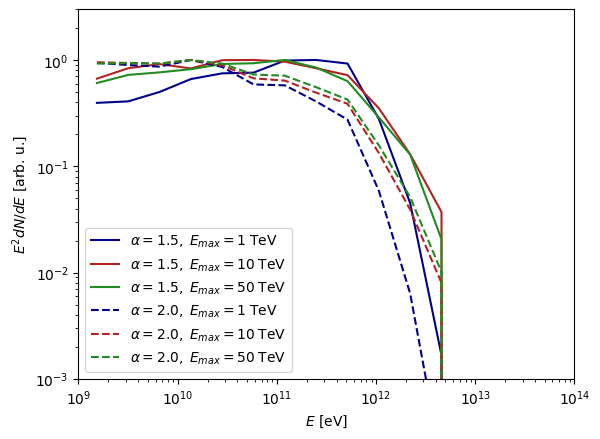

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

c1, c2, c3 = 'darkblue', 'firebrick', 'forestgreen'
ls1, ls2 = '-', '--'

plt.plot(x1, y1, ls = ls1, c = c1, label = '$\\alpha = 1.5, \\; E_{max} = 1  \\; \\mathrm{TeV}$')
plt.plot(x2, y2, ls = ls1, c = c2, label = '$\\alpha = 1.5, \\; E_{max} = 10 \\; \\mathrm{TeV}$')
plt.plot(x3, y3, ls = ls1, c = c3, label = '$\\alpha = 1.5, \\; E_{max} = 50 \\; \\mathrm{TeV}$')
plt.plot(x4, y4, ls = ls2, c = c1, label = '$\\alpha = 2.0, \\; E_{max} = 1  \\; \\mathrm{TeV}$')
plt.plot(x5, y5, ls = ls2, c = c2, label = '$\\alpha = 2.0, \\; E_{max} = 10 \\; \\mathrm{TeV}$')
plt.plot(x6, y6, ls = ls2, c = c3, label = '$\\alpha = 2.0, \\; E_{max} = 50 \\; \\mathrm{TeV}$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e9, 1e14)
plt.ylim(1e-3, 3.)
plt.ylabel('$E^2 dN/dE$ [arb. u.]')
plt.xlabel('$E$ [eV]')
plt.legend(loc = 'lower left')
plt.show()

